# **Music Classification Based on Audio Attributes**



## About the dataset


This dataset contains detailed metadata about songs collected from Spotify's API. It includes approximately 30,000 songs, covering a variety of attributes like track popularity, danceability, energy, and acoustic features. The primary goal is to explore relationships between song features and attributes such as their popularity or genres, and to identify patterns that might inform music classification or recommendation systems.

## **Preparation**

### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# nested cross validation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline

# models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# other tools
from itertools import combinations
from scipy.stats import randint
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import random

### Reading Dataset

In [ ]:
data = pd.read_csv('spotify_songs.csv')
data.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


### Attributes


*   **track_id**: Song unique ID
*   **track_name**: Song Name
*   **track_artist**: Song Artist
*   **track_popularity**: Song Popularity (0-100) where higher is better
*   **track_album_id**: Album unique ID
*   **track_album_name**: Song album name
*   **track_album_release_date**: Date when album released
*   **playlist_name**: Name of playlist
*   **playlist_id**: Playlist ID
*   **playlist_genre**: Playlist genre
*   **playlist_subgenre**: Playlist subgenre
*   **danceability**: Danceability measures how good a track is for dancing, based on factors like tempo, rhythm, beat strength, and consistency. It ranges from 0.0 (least danceable) to 1.0 (most danceable).
*   **energy**: Energy measures the intensity and activity of a track on a scale from 0.0 to 1.0.
*   **key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. If no key was detected, the value is -1.
*   **loudness**: Loudness measures how loud a track is in decibels (dB) and ranges between -60 to 0 db.
*   **mode**: Mode indicates whether a track is in a major (1) or minor (0) scale.
*   **speechiness**: Speechiness measures the amount of spoken words in a track, with values closer to 1.0 indicating more speech, and values below 0.33 representing mostly music.
*   **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
*   **instrumentalness**: Instrumentalness predicts whether a track has no vocals, with values closer to 1.0 indicating a higher likelihood of being vocal-free. Values above 0.5 suggest instrumental tracks, with greater confidence as the value approaches 1.0.
*   **liveness**: Liveness detects the presence of an audience, with higher values indicating a greater likelihood the track was performed live. Values above 0.8 suggest the track is likely live.
*   **valence**: Valence measures the musical positivity of a track, with higher values indicating a more positive mood (e.g., happy, cheerful) and lower values indicating a more negative mood (e.g., sad, angry).
*   **tempo**: Tempo is the estimated speed of a track in beats per minute (BPM), reflecting the pace based on the average beat duration.
*   **duration_ms**: Duration of song in milliseconds

## **Feature Engineering**
The song realse year is the most valuable information in the song realse date feature, since it might be correlated with the gerne that is popular during that year.

In [ ]:
# Convert to datetime format
data['track_album_release_date'] = pd.to_datetime(
    data['track_album_release_date'],
    format='%Y-%m-%d',
    errors='coerce'
)

# Create a new feature of release year
data['release_year'] = data['track_album_release_date'].dt.year

## **Data Cleaning**

### Drop Rows with NA and Irrelevant Columns

We begin by identifying all null values in the dataset to assess the extent of missing data and determine the appropriate strategy for handling them.

In [ ]:
print(data.isnull().sum())
print(f'\nTotal number of missing values: {data.isnull().sum().sum()}')

track_id                       0
track_name                     5
track_artist                   5
track_popularity               0
track_album_id                 0
track_album_name               5
track_album_release_date    1886
playlist_name                  0
playlist_id                    0
playlist_genre                 0
playlist_subgenre              0
danceability                   0
energy                         0
key                            0
loudness                       0
mode                           0
speechiness                    0
acousticness                   0
instrumentalness               0
liveness                       0
valence                        0
tempo                          0
duration_ms                    0
release_year                1886
dtype: int64

Total number of missing values: 3787


Since there are only a few missing values, we decide to drop them to maintain the integrity of the dataset and ensure consistent analysis.

In [ ]:
# Drop rows with missing or invalid values
data = data.dropna()

# As another part of data cleaning, we drop the columns we don't need. Additionally, we check to make sure that all the missing
# values have already being dropped
# Also drop irrelavant information
data = data.drop(labels=['track_album_release_date','track_album_name', 'playlist_name',
                         'playlist_subgenre', 'track_id','track_album_id','playlist_id'], axis=1)

# Move the class label to be the first column so that the view of the data is more intuitive
column_to_move = 'playlist_genre'
columns = [column_to_move] + [col for col in data.columns if col != column_to_move]
data = data[columns]

# Check if all the missing values are removed
print(data.isnull().sum())
print(f'\nTotal number of missing values: {data.isnull().sum().sum()}')

playlist_genre      0
track_name          0
track_artist        0
track_popularity    0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
release_year        0
dtype: int64

Total number of missing values: 0


### Normalization

To ensure that the features in the dataset are on a consistent and comparable scale, we apply MinMax scaling using the MinMaxScaler from the sklearn.preprocessing library. By normalizing the data in this manner, we ensure that each feature contributes equally, improving the model's convergence and overall performance.

In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
columns_to_normalize = ['loudness', 'key', 'tempo', 'duration_ms', 'track_popularity', 'release_year']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Check if the data is normalized
data.head()

,playlist_genre,track_name,track_artist,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,release_year
0,pop,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,0.66,0.748,0.916,0.545455,0.918090,1,0.0583,0.1020,0.000000,0.0653,0.518,0.509673,0.371254,0.984127
1,pop,Memories - Dillon Francis Remix,Maroon 5,0.67,0.726,0.815,1.000000,0.869162,1,0.0373,0.0724,0.004210,0.3570,0.693,0.417524,0.308674,0.984127
2,pop,All the Time - Don Diablo Remix,Zara Larsson,0.70,0.675,0.931,0.090909,0.901368,0,0.0742,0.0794,0.000023,0.1100,0.613,0.517908,0.335953,0.984127
3,pop,Call You Mine - Keanu Silva Remix,The Chainsmokers,0.60,0.718,0.930,0.636364,0.894118,1,0.1020,0.0287,0.000009,0.2040,0.277,0.509338,0.321311,0.984127
4,pop,Someone You Loved - Future Humans Remix,Lewis Capaldi,0.69,0.650,0.833,0.090909,0.875385,1,0.0359,0.0803,0.000000,0.0833,0.725,0.517775,0.360156,0.984127


### Removing Outliers
For each specified feature, it identifies and replaces outliers with the feature’s mean value. Filling with mean values is chosen because there are many overlapping between the outliers of different genre, so removing them takes away too much of the dataset. Also, mean values are more unique to each genre, that is the values vary between genres, so it is a better representation compared to values like mode.

In [ ]:
def remove_outliers(data, features):
  for feature in features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f'{feature} : {len(data[(data[feature] < lower_bound) | (data[feature] > upper_bound)])}')

    mean = data[feature].mean()
    data[feature] = data[feature].apply(lambda x: mean if (x < lower_bound or x > upper_bound) else x)

  return data;

## **Data Visualization**

### Genre Distribution
Groups the dataset by the playlist_genre column and then calculates the size of each group.

playlist_genre
edm      5969
latin    4961
pop      5303
r&b      5094
rap      5468
rock     4147
dtype: int64


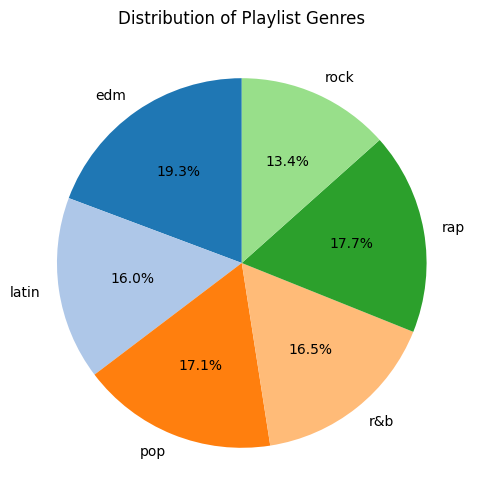

In [ ]:
# Look at the number of each genre
genre_counts = data.groupby('playlist_genre').size()
print(genre_counts)

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    genre_counts,
    labels=genre_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.tab20.colors
)
plt.title('Distribution of Playlist Genres')
plt.show()

### Feature vs Genre

Using boxplots to visualize how different audio features vary across different playlist genres. Each plot shows the distribution of a feature for each genre, allowing for comparisons of how these features are spread out or clustered within each genre.

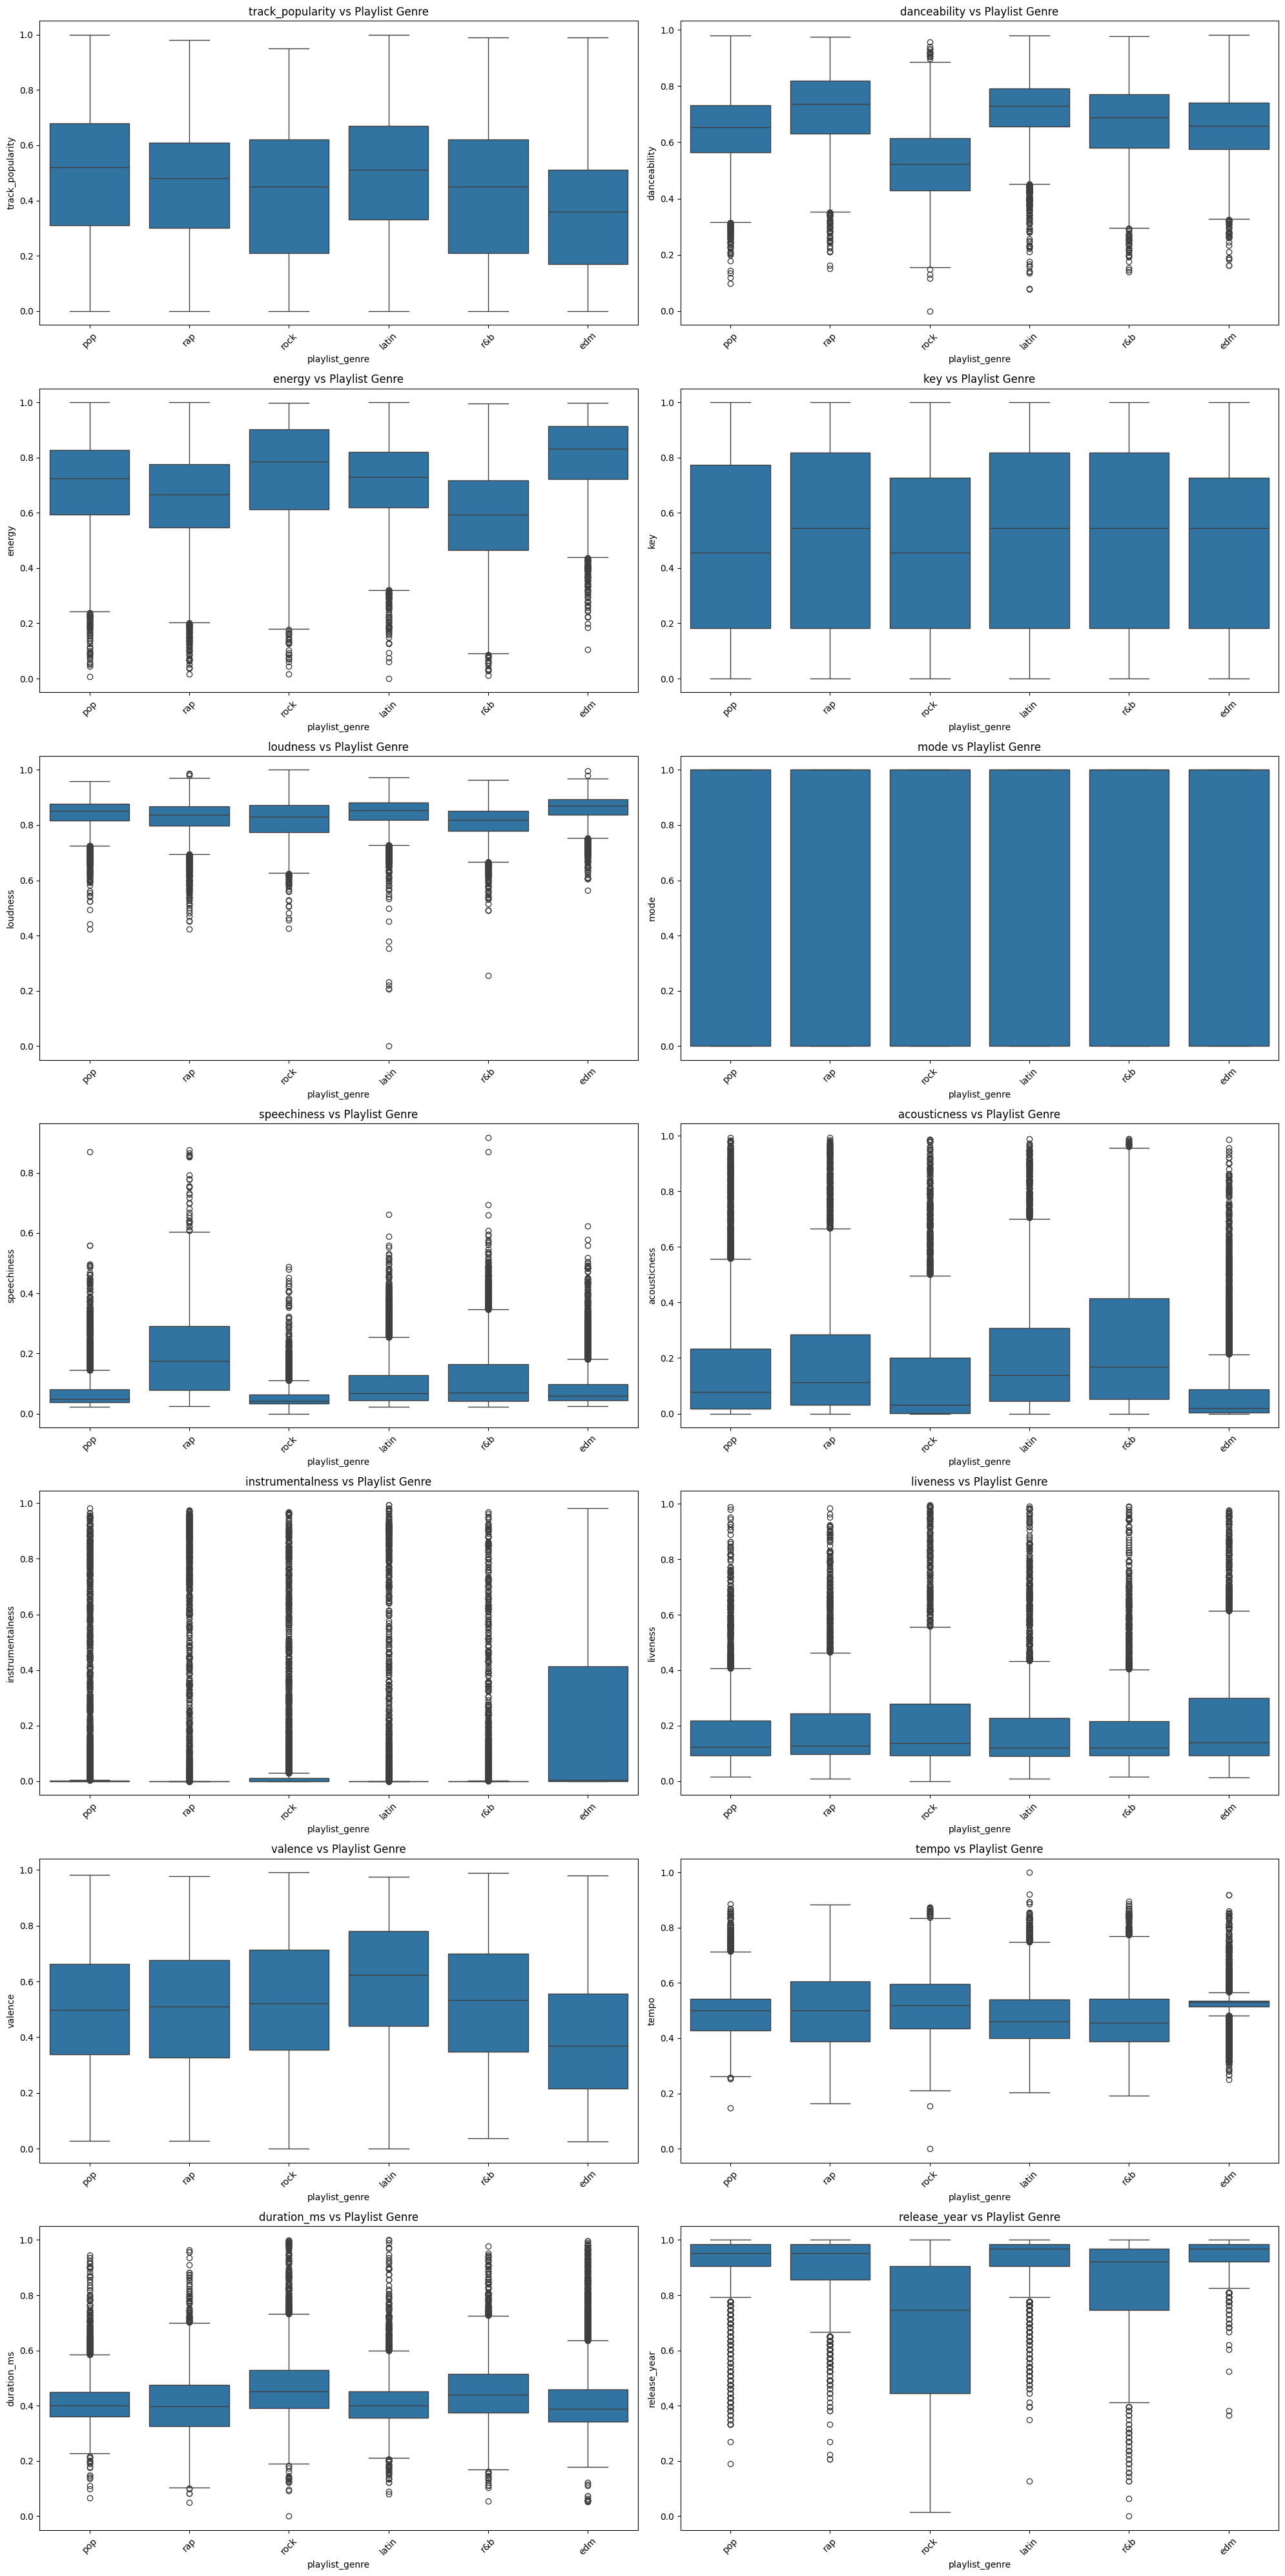

In [ ]:
all_features = ['track_popularity', 'danceability', 'energy', 'key',
            'loudness', 'mode', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'release_year']


plt.figure(figsize=(20, 40))
for i, feature in enumerate(all_features, 1):
    plt.subplot(7, 2, i)
    sns.boxplot(x='playlist_genre', y=feature, data=data)
    plt.title(f'{feature} vs Playlist Genre')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The box plots became more stable and focused after replacing the outliers with the mean values for each feature, which reduced the influence of extreme data points. As a result, the IQRs were narrower, and the box plots more accurately reflected the general trends in feature distributions.

### Feature Analysis and Categorization

The graphs were analyzed to assess how distinct the various genres are based on different audio features. Based on these observations, the features were categorized into three groups: Good, Maybe, and Bad.

Good Features:
* **Danceability/Speechiness**: Varies greatly across genres.
* **Energy**: Indicates the intensity and activity of a track, useful for differentiating energetic genres like EDM.
* **Instrumentalness**: Particularly useful in distinguishing EDM from other genres, where instrumental tracks are more common.
* **Tempo**: The speed of a track, which can help differentiate genres like rap.
* **Valence**: Captures the positivity or happiness of a track, a key differentiator in genres like latin.
* **Track Popularity**: Pop and Latin seem to have higher popularity than other genres.
* **Release Year**: It's very good at distinguishing rock because they are realeased much earlier than over genres.

Maybe Good Features:
* **Acousticness**: While useful in some contexts, it does not strongly distinguish genres on its own.
* **Loudness**: Can differentiate genres like R&B, but its effectiveness varies across genres.
* **Liveness**: Somewhat indicative of certain genres but less distinct.
* **Duration_ms**: The length of a track may be useful in certain cases but is not always reliable for genre classification.


Bad Feature:
* **Key/Mode**: These features were found to be less informative for distinguishing between genres, as it does not provide a clear differentiation.

Note:
These categorization wasn't used in the final model, but they were helpful in help us getting started.

### Feature vs Genre after removing outliers


track_popularity : 0
danceability : 299
energy : 272
key : 0
loudness : 963
mode : 0
speechiness : 2934
acousticness : 2061
instrumentalness : 6660
liveness : 1740
valence : 0
tempo : 599
duration_ms : 1362
release_year : 2938


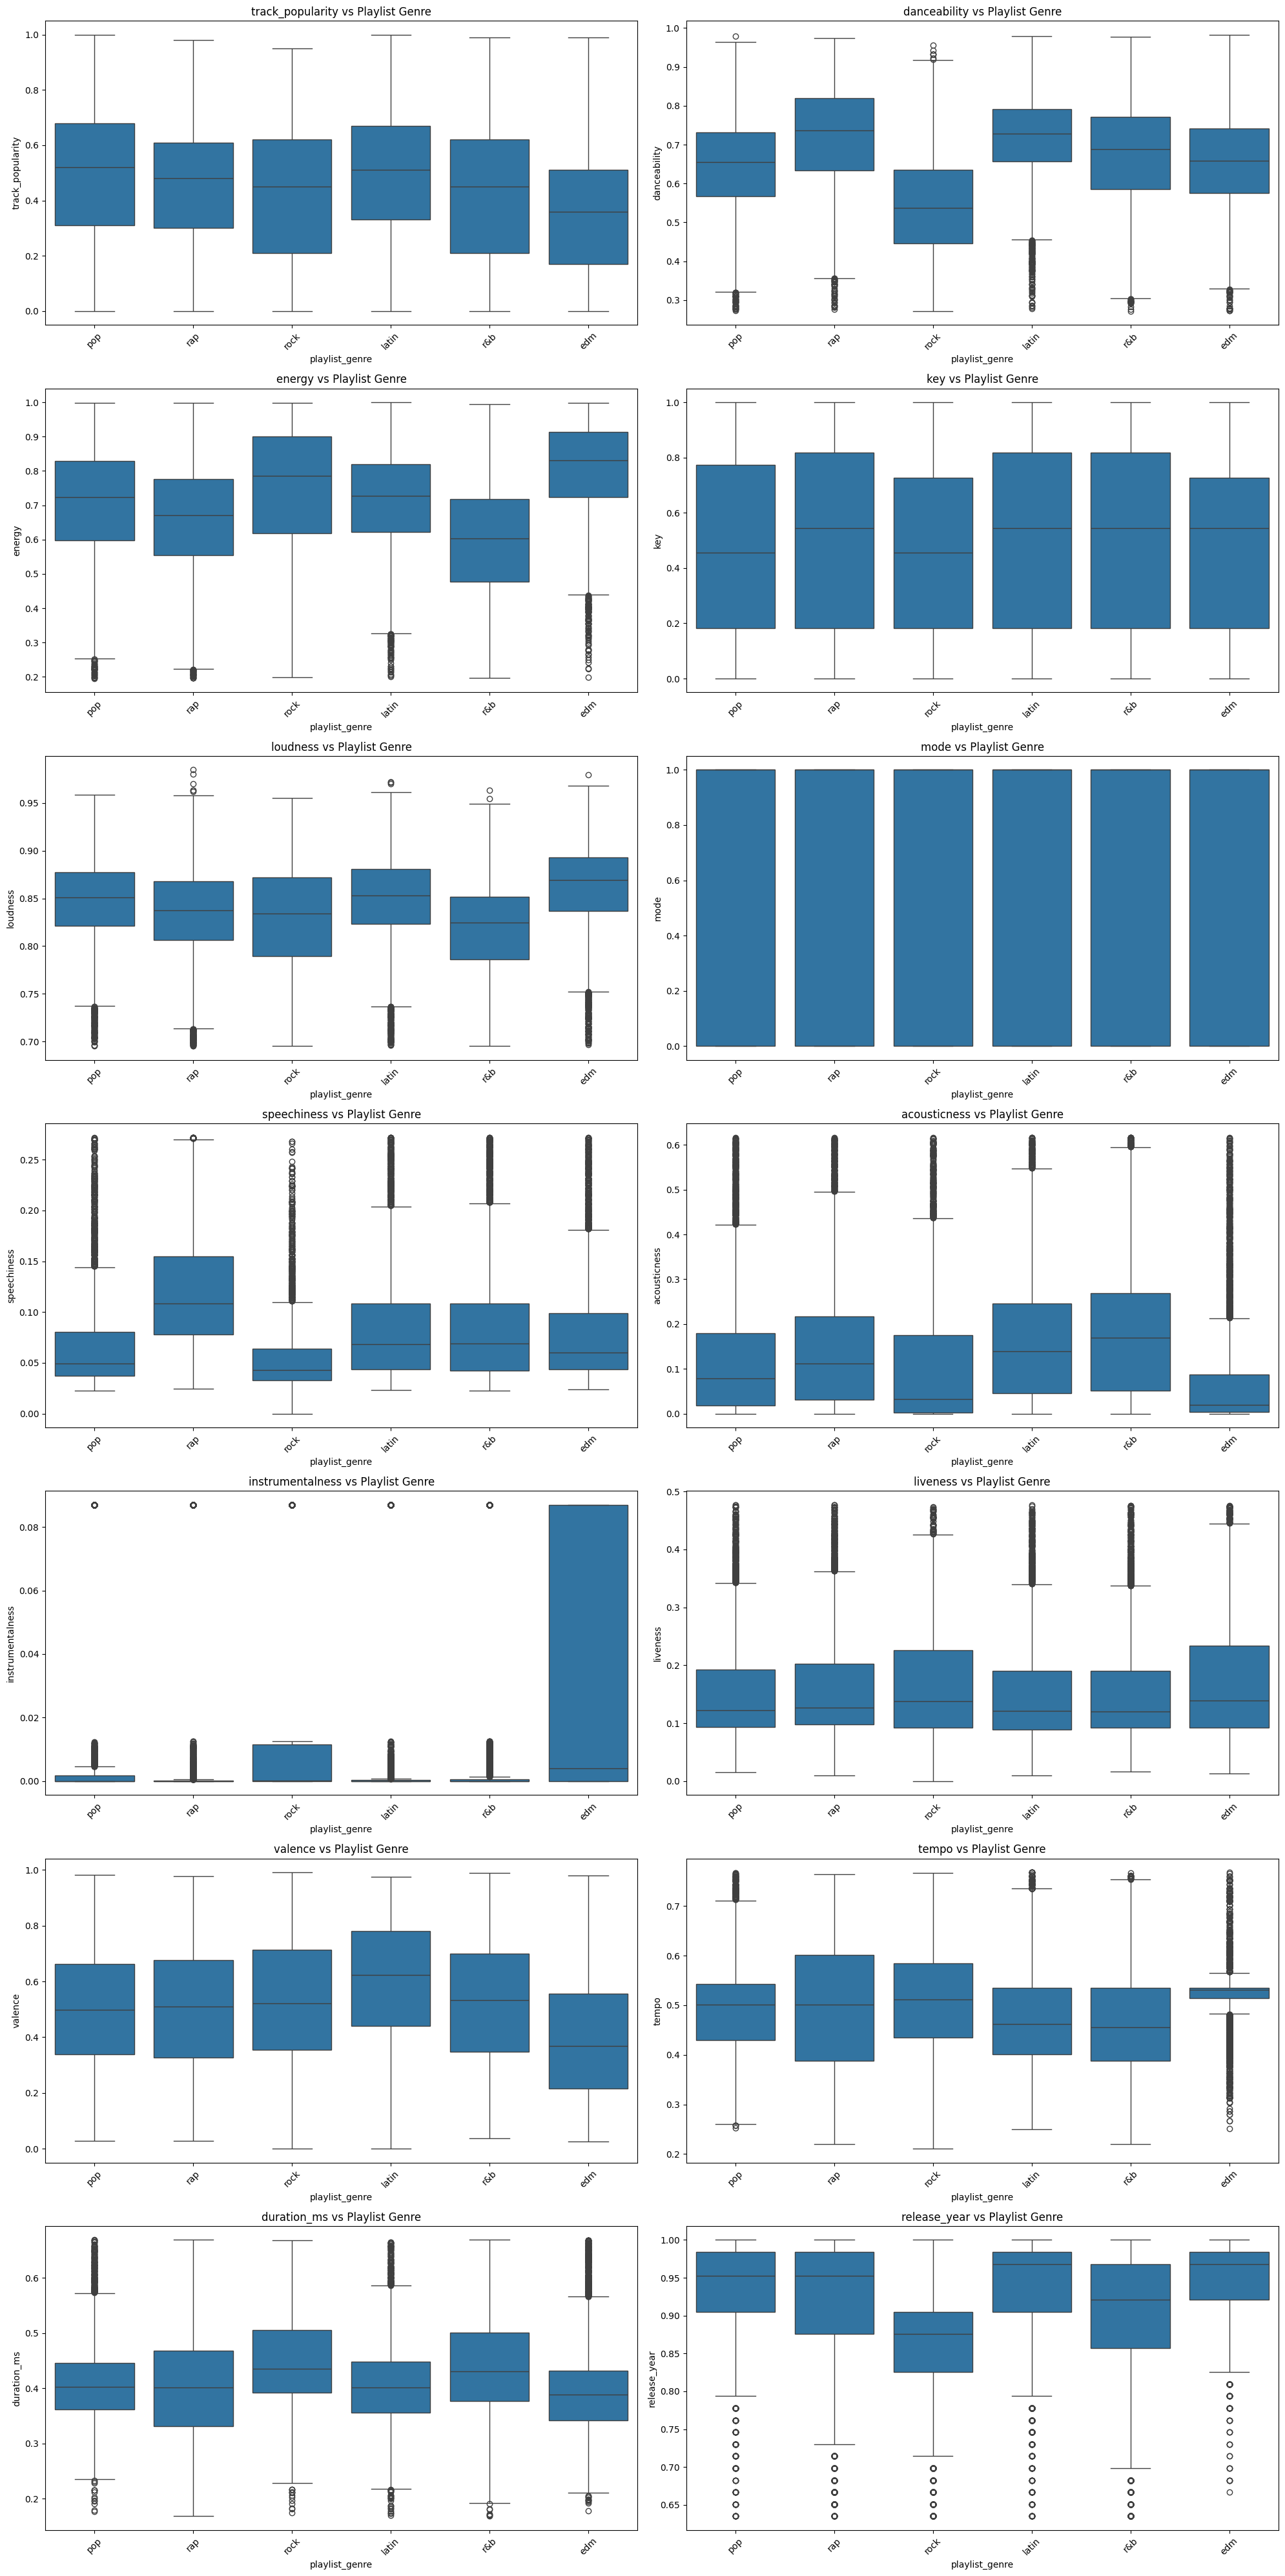

In [ ]:
data_no = data.copy()
data_no = remove_outliers(data_no, all_features)

plt.figure(figsize=(20, 40))
for i, feature in enumerate(all_features, 1):
    plt.subplot(7, 2, i)
    sns.boxplot(x='playlist_genre', y=feature, data=data_no)
    plt.title(f'{feature} vs Playlist Genre')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## **Model Definition**

We use the following different machine learning models for the dataset:


1.   Naive Bayes
2.   K-Nearest Neighbour Classifier
3.   Random Forest
4.   Support Vector Machine



In [ ]:
# Prepare for nested cross validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=30)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=30)

### Naive Bayes

In [ ]:
# Naive Bayes with Nested Cross Validation
def ncv_naive_bayes(X, y, Print=True, EntireReport=False):

    nb = GaussianNB()

    # Setting up the pipeline
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('nb', nb)
    ])

    nested_scores = []
    y_true_list = []
    y_pred_list = []
    X = np.array(X)
    y = np.array(y)

    if EntireReport:
        # Nested Cross Validation
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            y_true_list.extend(y_test)
            y_pred_list.extend(y_pred)
            fold_accuracy = np.mean(y_pred == y_test)
            nested_scores.append(fold_accuracy)

        class_report = classification_report(y_true_list, y_pred_list, digits=4)
        conf_matrix = confusion_matrix(y_true_list, y_pred_list)

        combined_results = list(zip(y_true_list, y_pred_list))
        random.shuffle(combined_results)
        example_results = combined_results[:10]

        print("\nClassification Report:")
        print(class_report)
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nExample Results (Actual vs. Predicted):")
        for actual, predicted in example_results:
            print(f"{actual}, {predicted}")
        print("\n")
    else:
        nested_scores = cross_val_score(pipeline, X, y, cv=outer_cv, scoring='accuracy')

    if Print:
        nested_scores = np.array(nested_scores)
        print(f'Naive Bayes Nested CV Accuracy Scores: {nested_scores}')
        print(f'Naive Bayes Mean Nested CV Accuracy: {nested_scores.mean()}')

    return nested_scores.mean()

### KNN

In [ ]:
# KNN with Nested Cross Validation
def ncv_knn(X, y, Print=True, EntireReport=False):

    knn = KNeighborsClassifier()

    # Setting up the pipeline
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('knn', knn)
    ])

    # Parameter Grid
    grid_params = {
        'knn__n_neighbors': range(1, 31)
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=grid_params,
        cv=inner_cv,
        scoring='accuracy'
    )

    nested_scores = []
    y_true_list = []
    y_pred_list = []
    X = np.array(X)
    y = np.array(y)

    if EntireReport:
        # Nested Cross Validation
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.best_estimator_.predict(X_test)
            y_true_list.extend(y_test)
            y_pred_list.extend(y_pred)
            fold_accuracy = np.mean(y_pred == y_test)
            nested_scores.append(fold_accuracy)

        class_report = classification_report(y_true_list, y_pred_list, digits=4)
        conf_matrix = confusion_matrix(y_true_list, y_pred_list)

        combined_results = list(zip(y_true_list, y_pred_list))
        random.shuffle(combined_results)
        example_results = combined_results[:10]

        print("\nClassification Report:")
        print(class_report)
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nExample Results (Actual vs. Predicted):")
        for actual, predicted in example_results:
            print(f"{actual}, {predicted}")
        print("\n")
    else:
        nested_scores = cross_val_score(grid_search, X, y, cv=outer_cv)

    if Print:
        nested_scores = np.array(nested_scores)
        print(f'KNN Nested CV Accuracy Scores: {nested_scores}')
        print(f'KNN Mean Nested CV Accuracy: {nested_scores.mean()}')

    return nested_scores.mean()

### Random Forest

In [ ]:
# Random Forest with Nested Cross Validation
def ncv_random_forest(X, y, Print=True, EntireReport=False):

    rf = RandomForestClassifier(random_state=30)

    # Setting up the pipeline
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('rf', rf)
    ])

    # Parameter Grid
    grid_params = {
        'rf__n_estimators': randint(50, 150),
        'rf__max_depth': [None, 10, 20],
        'rf__min_samples_split': [2, 5],
        'rf__min_samples_leaf': [1, 2]
    }

    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=grid_params,
        cv=inner_cv,
        scoring='accuracy',
        n_iter=10,
        random_state=30
    )

    nested_scores = []
    y_true_list = []
    y_pred_list = []
    X = np.array(X)
    y = np.array(y)

    if EntireReport:
        # Nested Cross Validation
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            random_search.fit(X_train, y_train)
            y_pred = random_search.best_estimator_.predict(X_test)
            y_true_list.extend(y_test)
            y_pred_list.extend(y_pred)
            fold_accuracy = np.mean(y_pred == y_test)
            nested_scores.append(fold_accuracy)

        class_report = classification_report(y_true_list, y_pred_list, digits=4)
        conf_matrix = confusion_matrix(y_true_list, y_pred_list)

        combined_results = list(zip(y_true_list, y_pred_list))
        random.shuffle(combined_results)
        example_results = combined_results[:10]

        print("\nClassification Report:")
        print(class_report)
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nExample Results (Actual vs. Predicted):")
        for actual, predicted in example_results:
            print(f"{actual}, {predicted}")
        print("\n")
    else:
        nested_scores = cross_val_score(random_search, X, y, cv=outer_cv)

    if Print:
        nested_scores = np.array(nested_scores)
        print(f'Random Forest Nested CV Accuracy Scores: {nested_scores}')
        print(f'Random Forest Mean Nested CV Accuracy: {nested_scores.mean()}')


    return nested_scores.mean()

### SVM

In [ ]:
# SVM with Nested Cross Validation
def ncv_svm(X, y, Print=True, EntireReport=False):

    svm = SVC()
    # Reduce dimensionality
    pca = PCA()

    # Setting up the pipeline
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('pca', pca),
        ('svm', svm)
    ])

    # Parameter Grid
    grid_params = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__kernel': ['linear', 'rbf']
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=grid_params,
        cv=inner_cv,
        scoring='accuracy'
    )

    nested_scores = []
    y_true_list = []
    y_pred_list = []
    X = np.array(X)
    y = np.array(y)

    if EntireReport:
        # Nested Cross Validation
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            grid_search.fit(X_train, y_train)
            y_pred = grid_search.best_estimator_.predict(X_test)
            y_true_list.extend(y_test)
            y_pred_list.extend(y_pred)
            fold_accuracy = np.mean(y_pred == y_test)
            nested_scores.append(fold_accuracy)

        class_report = classification_report(y_true_list, y_pred_list, digits=4)
        conf_matrix = confusion_matrix(y_true_list, y_pred_list)

        combined_results = list(zip(y_true_list, y_pred_list))
        random.shuffle(combined_results)
        example_results = combined_results[:10]

        print("\nClassification Report:")
        print(class_report)
        print("\nConfusion Matrix:")
        print(conf_matrix)
        print(f"\nExample Results (Actual vs. Predicted):")
        for actual, predicted in example_results:
            print(f"{actual}, {predicted}")
        print("\n")
    else:
        nested_scores = cross_val_score(grid_search, X, y, cv=outer_cv)

    if Print:
        nested_scores = np.array(nested_scores)
        print(f'SVM Nested CV Accuracy Scores: {nested_scores}')
        print(f'SVM Mean Nested CV Accuracy: {nested_scores.mean()}')

    return nested_scores.mean()

## **Model Testing**


In the model testing process, we began by evaluating models on a small subset of the data to ensure the implementations worked as expected and to conduct preliminary performance checks.

For the second phase, where we ran the models with all the data, each model was evaluated with nested cross-validation using X (features) and y (target labels). The respective functions computed accuracy scores for each fold of the outer cross-validation, along with the mean accuracy score for the model across all folds.

### Test models on a small portion of the data

In [ ]:
# This is for testing purposes
# Use a small subset of the data to test if all models work
random_seed = 30
sample_size = 1000
data_subset = data.sample(n=sample_size, random_state=random_seed)
X = data_subset[all_features]
y = data_subset['playlist_genre']
nb_all_features_score = ncv_naive_bayes(X, y)
knn_all_features_score = ncv_knn(X, y)
rf_all_features_score = ncv_random_forest(X, y)
svm_all_features_score = ncv_svm(X, y)

"""
Output:
Naive Bayes Nested CV Accuracy Scores: [0.395 0.425 0.515 0.465 0.435]
Naive Bayes Mean Nested CV Accuracy: 0.44699999999999995
KNN Nested CV Accuracy Scores: [0.345 0.365 0.465 0.395 0.345]
KNN Mean Nested CV Accuracy: 0.383
Random Forest Nested CV Accuracy Scores: [0.465 0.545 0.56  0.53  0.555]
Random Forest Mean Nested CV Accuracy: 0.531
SVM Nested CV Accuracy Scores: [0.4  0.48 0.51 0.54 0.44]
SVM Mean Nested CV Accuracy: 0.47400000000000003
"""


Naive Bayes Nested CV Accuracy Scores: [0.395 0.425 0.515 0.465 0.435]
Naive Bayes Mean Nested CV Accuracy: 0.44699999999999995
KNN Nested CV Accuracy Scores: [0.345 0.365 0.465 0.395 0.345]
KNN Mean Nested CV Accuracy: 0.383


KeyboardInterrupt: 

Based on the results from the small dataset, we can predict that Random Forest will likely achieve the highest accuracy. This is expected, as Random Forest leverages the diversity of multiple decision trees within the ensemble, each focusing on different aspects of the data. This diversity helps reduce overfitting and enhances generalization, making the model particularly effective for complex datasets with numerous features, like ours.

###Testing with outliers removed

In [ ]:
data_subset_no = data_no.sample(n=sample_size, random_state=random_seed)
X_no = data_subset_no[all_features]
y_no = data_subset_no['playlist_genre']
nb_no_score = ncv_naive_bayes(X_no, y_no)
knn_no_score = ncv_knn(X_no, y_no)
rf_no_score = ncv_random_forest(X_no, y_no)
svm_no_score = ncv_svm(X_no, y_no)
"""
Naive Bayes Nested CV Accuracy Scores: [0.37  0.41  0.45  0.425 0.455]
Naive Bayes Mean Nested CV Accuracy: 0.422
KNN Nested CV Accuracy Scores: [0.285 0.37  0.44  0.365 0.33 ]
KNN Mean Nested CV Accuracy: 0.358
Random Forest Nested CV Accuracy Scores: [0.465 0.535 0.505 0.485 0.505]
Random Forest Mean Nested CV Accuracy: 0.49899999999999994
SVM Nested CV Accuracy Scores: [0.365 0.425 0.42  0.455 0.45 ]
SVM Mean Nested CV Accuracy: 0.42300000000000004
"""

Removing outliers led to a decrease in accuracy, likely because the method reduces the variability within each feature. By replacing extreme values with the mean, the features become less distinctive, causing the genres to appear more similar to one another. This reduction in feature diversity makes it more challenging for the model to differentiate between the genres, ultimately impacting its ability to make accurate predictions.

In [ ]:
"""
Results WITH PCA dimension reduction
Naive Bayes Mean Nested CV Accuracy: 0.429
KNN Mean Nested CV Accuracy: 0.381
Random Forest Mean Nested CV Accuracy: 0.461
SVM Mean Nested CV Accuracy: 0.47400000000000003

Results WITHOUT PCA dimension reduction
Naive Bayes Mean Nested CV Accuracy: 0.44699999999999995
KNN Mean Nested CV Accuracy: 0.381
Random Forest Mean Nested CV Accuracy: 0.522
SVM Mean Nested CV Accuracy: 0.47300000000000003

Comparing the results with and without PCA, we can determine which models should use PCA
"""

### Run models with all the data

In [ ]:
# Prepare data for input to the models
X = data[all_features]
y = data['playlist_genre']

In [ ]:
nb_all_features_score = ncv_naive_bayes(X, y)

"""
Output:
Naive Bayes Nested CV Accuracy Scores: [0.46033285 0.4824689  0.46654816 0.46574014 0.47705236]
Naive Bayes Mean Nested CV Accuracy: 0.4704284808744334
"""

Naive Bayes Nested CV Accuracy Scores: [0.46033285 0.4824689  0.46654816 0.46574014 0.47705236]
Naive Bayes Mean Nested CV Accuracy: 0.4704284808744334


In [ ]:
knn_all_features_score = ncv_knn(X, y)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
rf_all_features_score = ncv_random_forest(X, y)

In [ ]:
svm_all_features_score = ncv_svm(X, y)

## **Feature Selection**

Because running the models is time-consuming, except for Naive Bayes, we used Naive Bayes to identify the best combination of features. To evaluate feature importance, we tested each feature individually to assess its predictive power, excluded one feature at a time to observe its impact on model performance, and tested all possible feature combinations. These methods helped us understand both individual and collective contributions of features to the model.

We ran naive valid_features = ['energy', 'speechiness', 'valence', 'tempo', 'duration_ms']
Nested CV Accuracy Scores: [0.43847091 0.43131282 0.44151691 0.43168317 0.44447829]
Mean Nested CV Accuracy: 0.4556672760511883

valid_features = ['energy', 'danceability', 'valence', 'tempo', 'duration_ms']
Nested CV Accuracy Scores: [0.45720378 0.45004569 0.44821809 0.45803503 0.46397563]
Mean Nested CV Accuracy: 0.4556672760511883


Valid_features = 'danceability', 'energy', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'duration_ms'
Accuracy: 0.486745886654479

### Test Each Feature Individually

In [ ]:
best_score_individual = 0
best_feature_individual = None

for feature in all_features:

    # Use only one feature
    X_subset = data[[feature]]

    mean_score = ncv_naive_bayes(X_subset, y, False)

    # Update best score
    if mean_score > best_score_individual:
        best_score_individual = mean_score
        best_feature_individual = feature

    print(f'Only {feature}: {mean_score}')

# Print the best individual feature results
print(f'Best Mean Nested CV Accuracy for Naive Bayes with a single feature: {best_score_individual}')
print(f'Best feature: {best_feature_individual}')

Only track_popularity: 0.24019132616691855
Only danceability: 0.2787797970897968
Only energy: 0.2779069366663105
Only key: 0.19164872556278562
Only loudness: 0.24145147003206371
Only mode: 0.19229526853061968
Only speechiness: 0.24516794450357793
Only acousticness: 0.24129021159901373
Only instrumentalness: 0.21643734118428312
Only liveness: 0.19484840433059758
Only valence: 0.24361711349963752
Only tempo: 0.2811709433391165
Only duration_ms: 0.21983048933805968
Only release_year: 0.2786502273827985
Best Mean Nested CV Accuracy for Naive Bayes with a single feature: 0.2811709433391165
Best feature: tempo


### Test Using All Features Excluding One

In [ ]:
best_score_exclude_one = 0
worst_feature_excluded = None

for feature in all_features:

    # Use all features excluding one feature
    X_subset = data[[f for f in all_features if f != feature]]

    mean_score = ncv_naive_bayes(X_subset, y, False)

    # Update best score
    if mean_score > best_score_exclude_one:
        best_score_exclude_one = mean_score
        worst_feature_excluded = feature

    print(f'All Features Excluding {feature}: {mean_score}')

# Print the best results when excluding one feature
print(f'Best Mean Nested CV Accuracy for Naive Bayes excluding one feature: {best_score_exclude_one}')
print(f'Feature whose exclusion resulted in the best score: {worst_feature_excluded}')

All Features Excluding track_popularity: 0.4650635816428066
All Features Excluding danceability: 0.4466097084271644
All Features Excluding energy: 0.46040975173021587
All Features Excluding key: 0.47094556902517903
All Features Excluding loudness: 0.4713656692029137
All Features Excluding mode: 0.46890945870872314
All Features Excluding speechiness: 0.43684942935748444
All Features Excluding acousticness: 0.46745531800848167
All Features Excluding instrumentalness: 0.45585266434401045
All Features Excluding liveness: 0.46997593996396436
All Features Excluding valence: 0.4628336050479702
All Features Excluding tempo: 0.45788880077180955
All Features Excluding duration_ms: 0.46671178706763666
All Features Excluding release_year: 0.44832264909394165
Best Mean Nested CV Accuracy for Naive Bayes excluding one feature: 0.4713656692029137
Feature whose exclusion resulted in the best score: loudness


### Test All Different Combinations of features

In [ ]:
best_score_nb = 0
best_features_nb = None

# Starting from 10 features because using too few features yield poor results
for n_features in range(10, len(all_features) + 1):

    for combination in combinations(all_features, n_features):

        # Test different combination of features
        X_subset = data[list(combination)]

        mean_score = ncv_naive_bayes(X_subset, y, False)

        # Update best score
        if mean_score > best_score_nb:
            best_score_nb = mean_score
            best_features_nb = combination

        # print(f'{combination}: {mean_score}')

print(f'Best Mean Nested CV Accuracy for Naive Bayes: {best_score_nb}')
print(f'Best combination of features: {best_features_nb}')

After testing all possible combinations of features, the best mean nested CV accuracy achieved by Naive Bayes was **0.4720**. The optimal combination of features that contributed to this result includes:

* track_popularity
* danceability
* energy
* mode
* speechiness
* acousticness
* instrumentalness
* liveness
* valence
* tempo
* duration_ms
* release_year

## **Final Model**
For the final model, we utilized the best combination of features identified during the feature selection process.

In [ ]:
# Best Features: all features but key and loudness
best_features = ['track_popularity', 'danceability', 'energy',
            'mode', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo',
            'duration_ms', 'release_year']

# Prepare data for input to the models
X = data[best_features]
y = data['playlist_genre']

In [ ]:
nb_best_features_score = ncv_naive_bayes(X, y, True, True)

"""
Output:
Naive Bayes Nested CV Accuracy Scores: [0.46469543 0.48327678 0.46525533 0.46574014 0.48109244]
Naive Bayes Mean Nested CV Accuracy: 0.472012024169077
"""

Naive Bayes Nested CV Accuracy Scores: [0.46469543 0.48327678 0.46525533 0.46574014 0.48109244]
Naive Bayes Mean Nested CV Accuracy: 0.472012024169077


In [ ]:
knn_best_features_score = ncv_knn(X, y, True, True)

"""
Output:
KNN Nested CV Accuracy Scores: [0.49894975 0.52076264 0.50759535 0.5051713  0.5155139 ]
KNN Mean Nested CV Accuracy: 0.5095985871883337
"""

KNN Nested CV Accuracy Scores: [0.49894975 0.52076264 0.50759535 0.5051713  0.5155139 ]
KNN Mean Nested CV Accuracy: 0.5095985871883337


In [ ]:
rf_best_features_score = ncv_random_forest(X, y, True, True)

"""
Output:
Random Forest Nested CV Accuracy Scores: [0.57052836 0.57634513 0.57352941 0.57159017 0.57756949]
Random Forest Mean Nested CV Accuracy: 0.5739125121691915
"""

In [ ]:
svm_best_features_score = ncv_svm(X, y, True, True)
#accuracy: 0.54

Our Final Selection of the model is: random forest

The model that gives us the best results is random forest. We believe that is likely because random forest uses decision tree and our model sorts attributes into categories. Due to the various attributes available, the even distribution of data, and the categorical final output, decision tree through random forest has the best synergy with our goal.

If we randomly assign a result to a data point, the result would be 16.67% (1/6) correct. Our result is